In [1]:
import sys
import os

In [2]:
sys.path.append("/Volumes/VTG/Dev/C_5/Projects/week8")

In [3]:
import numpy as np 
from tqdm import tqdm
from sklearn.feature_extraction.text import HashingVectorizer
import torch 
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import pickle

from testing import Tester
from evaluator import evaluate

In [4]:
with open("../train.pkl", "rb") as f: 
    train_ds = pickle.load(f)

with open("../test.pkl", "rb") as f: 
    test_ds = pickle.load(f)

/Volumes/VTG/Dev/C_5/Projects/week8/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
### Documents for X / Price for y

y = np.array([float(item.price) for item in train_ds])
documents = [str(item).split("= $")[0].replace("<", "").strip() for item in train_ds]

In [6]:
# Use the HashingVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = HashingVectorizer(n_features=5000, stop_words="english", binary=True)
X = vectorizer.fit_transform(documents)

In [7]:
class NeuralNetwork(nn.Module): 
    def __init__(self, input_size): 
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 64) 
        self.layer6 = nn.Linear(64, 64)
        self.layer7 = nn.Linear(64, 64)
        self.layer8 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x): 
        output1 = self.relu(self.layer1(x))
        output2 = self.relu(self.layer2(output1))
        output3 = self.relu(self.layer3(output2))
        output4 = self.relu(self.layer4(output3))
        output5 = self.relu(self.layer5(output4)) 
        output6 = self.relu(self.layer6(output5)) 
        output7 = self.relu(self.layer7(output6)) 
        output8 = self.layer8(output7)

        return output8

In [8]:
### Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X.toarray())
y_train_tensor = torch.FloatTensor(y).unsqueeze(1)

### Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_tensor, 
    y_train_tensor, 
    test_size=0.01, 
    random_state=42
)

### Create the loader (batch size 64 has brought the besst outcome so far)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Initialize the model
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)

In [9]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params:,}")

Number of trainable parameters: 669,249


In [10]:
## Define loss function and optimizer 

loss_function = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 2

for epoch in range(EPOCHS): 
    model.train()
    
    for batch_X, batch_y in tqdm(train_loader): 
        optimizer.zero_grad() # clear old gradients

        ### forward pass, loss calculation, backward pass, optimizer
        outputs = model(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward() # compute new gradients
        optimizer.step() # update weights

    model.eval()
    with torch.no_grad(): 
        val_outputs = model(X_val)
        val_loss = loss_function(val_outputs, y_val)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.3f}, Val Loss: {val_loss.item():.3f}')

100%|██████████████████████████████████████████████████████████████████| 2321/2321 [00:08<00:00, 289.62it/s]


Epoch [1/2], Train Loss: 62307.336, Val Loss: 19154.904


100%|██████████████████████████████████████████████████████████████████| 2321/2321 [00:08<00:00, 272.24it/s]

Epoch [2/2], Train Loss: 37859.855, Val Loss: 18002.799


## Inference function

In [11]:
def neural_network(item): 
    model.eval()
    with torch.no_grad(): 
        vector = vectorizer.transform([item])
        vector = torch.FloatTensor(vector.toarray())
        result = model(vector)[0].item()

    return max(0, result)

In [12]:
test_items = [
    {
    "item": str(item).split("= $")[0].replace("<", "").strip(), 
    "price": item.price, 
    "title": item.title
    }
    for item in test_ds
]

1: Guess: $129.55 Truth: $249.99 Error: $120.44 SLE: 0.43 Item: Medicom Batman Hush Black Suit Version B...
2: Guess: $21.89 Truth: $3.99 Error: $17.90 SLE: 2.32 Item: ALTKOL S Hooks for Hanging, 15-Pack S Sh...
3: Guess: $43.86 Truth: $109.99 Error: $66.13 SLE: 0.82 Item: Nady RSM-5 Ribbon Microphone - Unique co...
4: Guess: $58.19 Truth: $6.97 Error: $51.22 SLE: 4.02 Item: PANDAFLY Acrylic Paint Pens for Rock Pai...
5: Guess: $148.53 Truth: $164.99 Error: $16.46 SLE: 0.01 Item: Mistel MD600RGB v3 60% Split Mechanical ...
6: Guess: $220.48 Truth: $204.00 Error: $16.48 SLE: 0.01 Item: SWITCH by Design Studio, Big Giant Plaid...
7: Guess: $244.08 Truth: $168.00 Error: $76.08 SLE: 0.14 Item: Polk Audio - A Pair of DB652 6.5" Coaxia...
8: Guess: $63.05 Truth: $15.00 Error: $48.05 SLE: 1.92 Item: 6 Pack of 2 Inch Acoustic Foam Panels- P...
9: Guess: $405.24 Truth: $378.32 Error: $26.92 SLE: 0.00 Item: Guild Guitars Jumbo Jr Mahogany Acoustic...
10: Guess: $88.99 Truth: $122.55 Error: $33.5

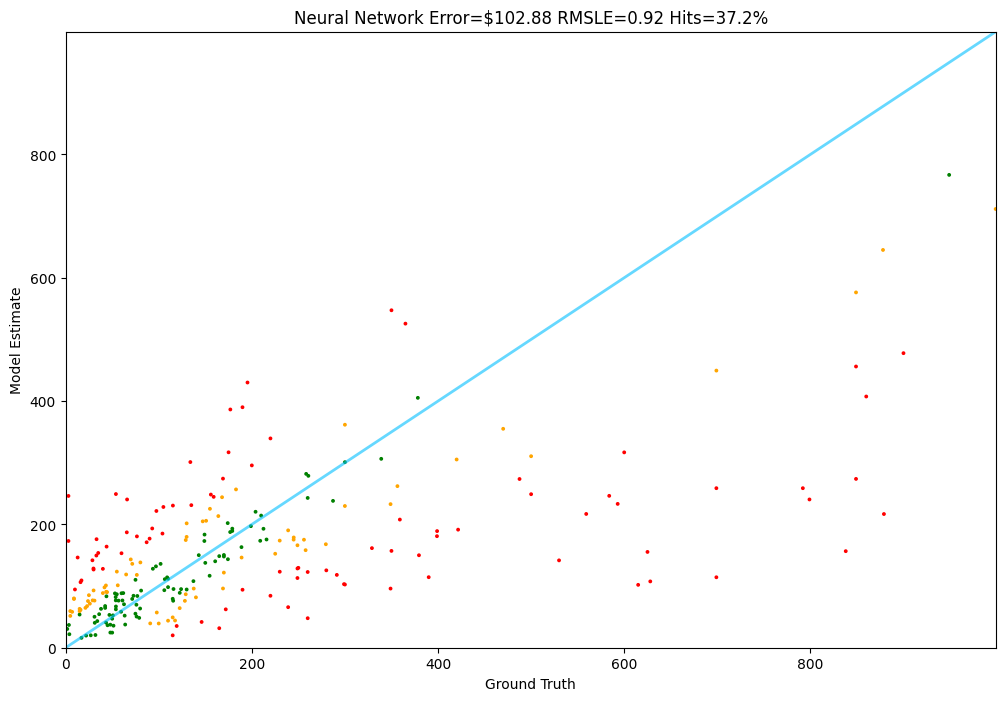

In [16]:
from testing_for_neural_network import TesterForNeuralNetwork

TesterForNeuralNetwork.test(neural_network, test_items)

## Save the neural network model

In [15]:
torch.save(model.state_dict(), "models/neural_network_pricer_model.pt")

import joblib
joblib.dump(vectorizer, "vectorizer.joblib")

['vectorizer.joblib']

In [16]:
print(type(vectorizer))

<class 'sklearn.feature_extraction.text.HashingVectorizer'>
